In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import *
from fastai.basic_data import *
from fastai.callbacks import CSVLogger
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
from PIL import Image
import cv2
# import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

In [2]:
import numpy as np
import torch
import pandas as pd
import random
import string

In [3]:
model_name = 'efficientnet-b2'

In [4]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained(model_name) 

Loaded pretrained weights for efficientnet-b2


In [5]:
np.random.seed(42)

In [6]:
image_size = EfficientNet.get_image_size(model_name)

In [7]:
data_dir = '../../data/train/'

In [8]:
src = (ImageList.from_folder(path=data_dir).split_by_rand_pct(0.2).label_from_folder())

In [9]:
res = []
res.append(rotate(degrees=(-90,90), p=1))

In [10]:
tfms=(res,[])

In [11]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH).databunch(bs=32).normalize(imagenet_stats))

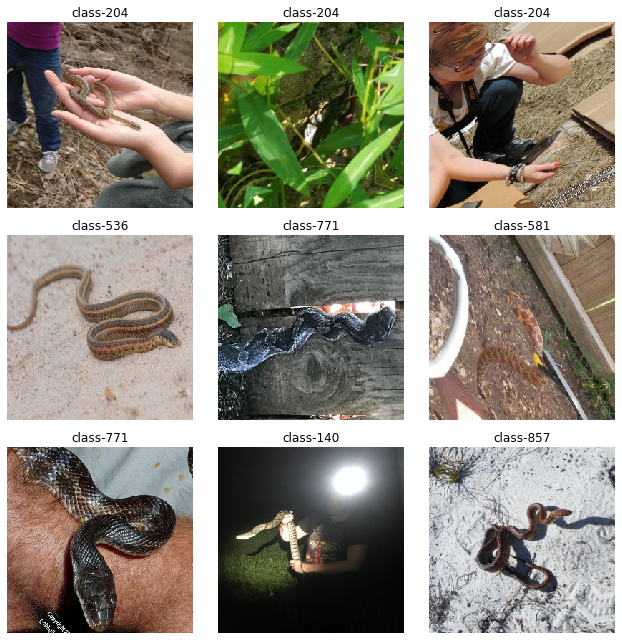

In [12]:
data.show_batch(3,figsize=(9,9))

In [13]:
list(children(model))[-2:]

[Linear(in_features=1408, out_features=1000, bias=True),
 MemoryEfficientSwish()]

In [14]:
model.add_module('_fc',nn.Linear(1408, data.c))

In [15]:
loss_func = LabelSmoothingCrossEntropy()

In [16]:
RMSprop = partial(torch.optim.RMSprop)

In [17]:
from torch.optim import Optimizer

In [18]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [19]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='micro'),kappa, top_k_accuracy, Precision(average='micro'),Recall(average='micro')],callback_fns=[partial(CSVLogger, filename=model_name, append=True)]).to_fp16()

In [20]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
             [learn.model._blocks[8:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])
print("pls")

pls


In [21]:
# learn = learn.load("b3_v2_best_40")

In [22]:
lr=1e-3

In [23]:
learn.fit_one_cycle(20,max_lr=slice(lr/100,lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best_b2_v0')])

epoch,train_loss,valid_loss,accuracy,f_beta,kappa_score,top_k_accuracy,precision,recall,time
0,1.942565,1.837567,0.605958,0.605958,0.602253,0.892617,0.605958,0.605958,20:06
1,1.928707,1.812617,0.621974,0.621974,0.599380,0.893345,0.621974,0.621974,20:06
2,1.855046,1.830886,0.611175,0.611175,0.569276,0.894619,0.611175,0.611175,20:06
3,1.776164,1.746081,0.645089,0.645089,0.620250,0.896317,0.645089,0.645089,20:08
4,1.714597,1.717146,0.652854,0.652854,0.622228,0.906813,0.652854,0.652854,20:08
5,1.661925,1.655897,0.674877,0.674877,0.666461,0.912880,0.674877,0.674877,20:06
6,1.577506,1.645164,0.683128,0.683128,0.666018,0.914215,0.683128,0.683128,20:04
7,1.513481,1.591652,0.701025,0.000000,0.668492,0.921920,nan,0.701025,20:06
8,1.445838,1.697886,0.659467,0.659467,0.629249,0.909361,0.659467,0.659467,20:06
9,1.397233,1.563247,0.707456,0.707456,0.691345,0.928411,0.707456,0.707456,20:07


Better model found at epoch 0 with accuracy value: 0.6059576272964478.
Better model found at epoch 1 with accuracy value: 0.6219741702079773.
Better model found at epoch 3 with accuracy value: 0.6450888514518738.
Better model found at epoch 4 with accuracy value: 0.6528544425964355.
Better model found at epoch 5 with accuracy value: 0.6748771667480469.
Better model found at epoch 6 with accuracy value: 0.6831280589103699.
Better model found at epoch 7 with accuracy value: 0.7010253071784973.
Better model found at epoch 9 with accuracy value: 0.7074561715126038.
Better model found at epoch 10 with accuracy value: 0.7279621362686157.
Better model found at epoch 12 with accuracy value: 0.7348783612251282.
Better model found at epoch 13 with accuracy value: 0.7433719635009766.
Better model found at epoch 14 with accuracy value: 0.7527149319648743.
Better model found at epoch 15 with accuracy value: 0.7533822655677795.
Better model found at epoch 16 with accuracy value: 0.7653340101242065.


In [24]:
save_name = model_name+"v0_trained_for_20"
learn.save(save_name, return_path=True)

PosixPath('../../data/train/models/efficientnet-b2v0_trained_for_20.pth')

In [28]:
save_name = model_name+".pkl"
learn.export(save_name)

In [27]:
learn.export?

Signature:
learn.export(
    file:Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO]='export.pkl',
    destroy=False,
)
Docstring: Export the state of the `Learner` in `self.path/file`. `file` can be file-like (file or buffer)
File:      ~/.conda/envs/snakes/lib/python3.6/site-packages/fastai/basic_train.py
Type:      method
